In [ ]:
# This cell will help us plot the convergence of the model in real time
!pip install pycm livelossplot
%pylab inline

In [ ]:
# This cell performs all the imports that we will need in this coursework
from sklearn.metrics import accuracy_score # this allows us to evaluate our model at every iteration
from sklearn.metrics import f1_score # this allows us to evaluate our validation accuracy
from sklearn.model_selection import StratifiedShuffleSplit # this allows us to create a random validation split

# These imports help plot the convergence and create the confusion matrix
from livelossplot import PlotLosses
from pycm import *

# These imports help us create models and datasets
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

# This allows me to create my own custom dataset
from torch.utils.data import Dataset 

# This allows me to import pretrained models for transfer learning
import torchvision.models as torchmodels

# This allows me to do a number of transforms for data augmentation later on
from torchvision.transforms import Compose, ToTensor, Resize, Normalize, RandomApply, RandomChoice, RandomRotation, RandomCrop, RandomHorizontalFlip, RandomAffine, ToPILImage

# These imports help us write the submission file
import json, csv


In [ ]:
# This functions sets up all our random seeds so that the results will be reproducible
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

# Enable hardware acceleration
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

In [ ]:
means = [0.485, 0.456, 0.406]
stds = [0.229, 0.224, 0.225]
transform_vgg16_train = Compose([
    # ToPILImage(),
    Resize(224),
    RandomApply([RandomChoice([RandomCrop(size=[224, 224], padding=10), 
                               RandomAffine(0, translate=(0.01, 0.01))])]), # choose one or 0 transforms that make the image smaller
    RandomApply([RandomChoice([RandomHorizontalFlip(), RandomRotation(10)])]), # choose one or zero transforms to rotate or flip the image
    ToTensor(),
    Normalize(mean=means, std=stds), 
]) ##Compose different transforms together. PIL is Python Imaging Library useful for opening, manipulating, and saving many different image file formats.

In [ ]:
# Hyperparameter
seed = 42
lr = 1e-2
momentum = 0.5
batch_size = 36 # Mini-batch mode
test_batch_size = 500
n_epochs = 30

In [ ]:
# Read the dataset from the default folder
# Tiny-imagenet-200
my_data = training = ImageFolder("../input/acse-miniproject/train/",transform = transform_vgg16_train ) #/content/gdrive/My Drive/ACSE4-ML-miniproject/train

In [ ]:
test_data = ImageFolder("../input/acse-miniproject/test/", transform_vgg16_train)

In [ ]:
test_loader = DataLoader(test_data, batch_size=test_batch_size, shuffle=False, num_workers=0)

In [ ]:
# Split validation and training
train_size = int(0.9 * len(my_data))
validation_size = len(my_data) - train_size
train_dataset, validation_dataset = random_split(my_data, [train_size, validation_size])
# DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
validation_loader = DataLoader(validation_dataset, batch_size=test_batch_size, shuffle=False, num_workers=0)

In [ ]:
# # First import resnet from models, it is pretrained on imagenet and we will keep those weights to detect features
# # vgg13 = torchmodels.vgg13(pretrained=True)
# vgg11 = torchmodels.vgg11(pretrained=True)

In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [45]:
input_size = 299
feature_extract = True
model_ft = torchmodels.inception_v3(pretrained=True)
for param in model_ft.parameters():
        param.requiresgrad = False

model_ft.AuxLogits.fc = nn.Linear(768, 200)
model_ft.fc = nn.Linear(2048,200)
model_ft.aux_logits = False


        
# set_parameter_requires_grad(model_ft, feature_extract)
# # Handle the auxilary net
# num_ftrs = model_ft.AuxLogits.fc.in_features
# model_ft.AuxLogits.fc = nn.Linear(num_ftrs, 200)
#         # Handle the primary net
# num_ftrs = model_ft.fc.in_features
# model_ft.fc = nn.Linear(num_ftrs,200)




In [46]:
print(model_ft)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In [47]:
data_transforms = transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
test_transforms = transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [ ]:
my_data = training = ImageFolder("../input/acse-miniproject/train/",transform = data_transforms ) #/content/gdrive/My Drive/ACSE4-ML-miniproject/train

In [ ]:
test_data = ImageFolder("../input/acse-miniproject/test/", test_transforms)

In [ ]:
# # Freeze the weights in the earlier layers:
# for param in vgg16.parameters():
#     param.requires_grad = False

# print(vgg16)

# vgg16 has 16 layers with the last 4 are fc layers
# unfreeze the last layer so it learns on our dataset
# layer_num = 0
# for child in vgg11.children():
#   layer_num += 1
#   if layer_num < 11:
#       for param in child.parameters():
#           param.requires_grad = False
# # vgg16.fc = nn.Linear(num_ftrs, 10) # change number of output classes
# num_classes = 200
# num_ftrs = vgg11.classifier[6].in_features
# vgg11.classifier[6] = nn.Linear(num_ftrs,num_classes)# change number of output classes


In [48]:
def train(model, optimizer, criterion, data_loader):
    model.train()
    train_loss, train_accuracy = 0, 0
    for X, y in data_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        a2 = model(X.view(-1, 3, 224, 224)) # when transferring vgg later on, it takes 224x224 inputs rather than 32x32
        loss = criterion(a2, y)
        loss.backward()
        train_loss += loss*X.size(0)
        y_pred = F.log_softmax(a2, dim=1).max(1)[1]
        train_accuracy += accuracy_score(y.cpu().numpy(), y_pred.detach().cpu().numpy())*X.size(0)
        optimizer.step()
         
    return train_loss/len(data_loader.dataset), train_accuracy/len(data_loader.dataset)
def validate(model, criterion, data_loader):
  model.eval()
  validation_loss, validation_accuracy = 0., 0.
  for X, y in data_loader:
    with torch.no_grad():
      X, y = X.to(device), y.to(device)
      a2 = model(X.view(-1, 3, 224, 224)) # when transferring vgg later on, it takes 224x224 inputs rather than 32x32
      loss = criterion(a2, y)
      validation_loss += loss*X.size(0)
      y_pred = F.log_softmax(a2, dim=1).max(1)[1]
      validation_accuracy += accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())*X.size(0)
      
  return validation_loss/len(data_loader.dataset), validation_accuracy/len(data_loader.dataset)

def evaluate(model, data_loader):
  model.eval()
  ys, y_preds = [], []
  for X, y in data_loader:
    with torch.no_grad():
      X, y = X.to(device), y.to(device)
      a2 = model(X.view(-1, 3, 224, 224)) # when transferring vgg later on, it takes 224x224 inputs rather than 64x64
      y_pred = F.log_softmax(a2, dim=1).max(1)[1]
      ys.append(y.cpu().numpy())
      y_preds.append(y_pred.cpu().numpy())
            
  return np.concatenate(y_preds, 0),  np.concatenate(ys, 0)

def predict(model, data_loader):
  model.eval()
  files, y_preds = [], []
  for X, y, z in data_loader:
      with torch.no_grad():
        X, y = X.to(device), y.to(device)
        a2 = model(X.view(-1, 3, 224, 224)) # when transferring vgg later on, it takes 224x224 inputs rather than 64x64
        y_pred = F.log_softmax(a2, dim=1).max(1)[1]
        y_preds.append(y_pred.cpu().numpy())
        files.append(z)
            
  return np.concatenate(y_preds, 0), np.concatenate(files, 0) 

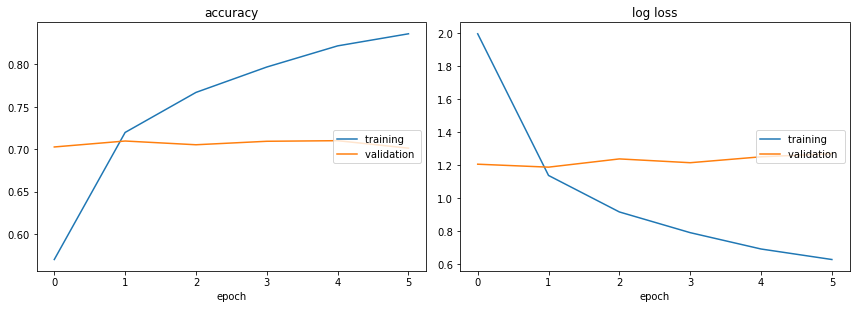

accuracy
	training         	 (min:    0.570, max:    0.836, cur:    0.836)
	validation       	 (min:    0.701, max:    0.710, cur:    0.701)
log loss
	training         	 (min:    0.629, max:    1.998, cur:    0.629)
	validation       	 (min:    1.189, max:    1.271, cur:    1.271)


In [49]:

# model = vgg11.to(device)
model = model_ft.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=1e-3)
criterion = nn.CrossEntropyLoss()

liveloss = PlotLosses()
for epoch in range(6):
    logs = {}
    train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)
    
    logs['' + 'log loss'] = train_loss.item()
    logs['' + 'accuracy'] = train_accuracy.item()
    
    validation_loss, validation_accuracy = validate(model, criterion, validation_loader)
   
    logs['val_' + 'log loss'] = validation_loss.item()
    logs['val_' + 'accuracy'] = validation_accuracy.item()
    
    liveloss.update(logs)
    liveloss.draw()

In [ ]:
y_pred, y_true = evaluate(model, validation_loader)

f1 = f1_score(y_true, y_pred, average="macro")
print(f1)

In [ ]:
my_predictions, my_files = predict(resnet2, test_loader)

my_files_clean = [my_files[i][38:] for i in range(len(my_files))]

with open('submission.csv', 'w', encoding="ISO-8859-1", newline='') as myfile:
    wr = csv.writer(myfile)
    wr.writerow(("Filename", "Label"))
    wr.writerows(zip(my_files_clean,my_predictions))

In [ ]:
# Save the augmented model:
model_save_name = 'GoogleNet_inception_v3.pth'
path = F"./{model_save_name}" 
torch.save(model.state_dict(), path)